### Import Libraries

Import necessary libraries

In [1]:
import glob
import os
import librosa
import librosa.display
import time
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import noisereduce as nr
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage.io
import re
import pathlib
from IPython.display import display, Image
# %matplotlib inline
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from pydub.effects import normalize

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow_io as tfio

2022-09-24 08:24:15.687843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 08:24:15.954888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 08:24:15.954904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-24 08:24:15.980855: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-24 08:24:18.532520: W tensorflow/stream_executor/platform/de

In [2]:
class CFG:
    wandb = True
    project = "fake-speech-detection"
    debug = False
    exp_name = "v0"
    comment = "Conformer-128x80-cosine-no_aug-no_fc"

    # Use verbose=0 for silent, 1 for interactive
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Model & Backbone
    model_name = "Conformer"

    # Seeding for reproducibility
    seed = 101

    # Audio params
    sample_rate = 16000
    duration = 3.0 # duration in second
    audio_len = int(sample_rate * duration)
    normalize = True

    # Spectrogram params
    spec_freq = 128 # freq axis
    n_fft = 2048
    # spec_time = 256 # time axis
    # hop_len = audio_len//(spec_time - 1) # non-overlap region
    hop_len = n_fft // 4 # non-overlap region
    spec_time = (n_fft + 1) // hop_len # time axis
    fmin = 20
    fmax = sample_rate//2 # max frequency
    spec_shape = [spec_time, spec_freq] # output spectrogram shape
    
    # Audio Augmentation
    timeshift_prob = 0.0
    gn_prob = 0.0
    
    # Spectrogram Augmentation
    time_mask = 20
    freq_mask = 10
    cutmix_prob = 0.0
    cutmix_alpha = 2.5
    mixup_prob = 0.0
    mixup_alpha = 2.5

    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 12
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "binary_crossentropy"
    optimizer = "Adam"
    lr = 1e-4
    lr_schedule = "cosine"

    # Augmentation
    augment = False

    # Clip values to [0, 1]
    clip = False

In [3]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

# Trim Audio to ignore silent part in the start and end
def TrimAudio(audio, epsilon=0.15):
    pos  = tfio.audio.trim(audio, axis=0, epsilon=epsilon)
    audio = audio[pos[0]:pos[1]]
    return audio

# Crop or Pad audio to keep a fixed length
def CropOrPad(audio, target_len, pad_mode='constant'):
    audio_len = tf.shape(audio)[0]
    if audio_len < target_len: # if audio_len is smaller than target_len then use Padding
        diff_len = (target_len - audio_len)
        pad1 = random_int([], minval=0, maxval=diff_len) # select random location for padding
        pad2 = diff_len - pad1
        pad_len = [pad1, pad2]
        audio = tf.pad(audio, paddings=[pad_len], mode=pad_mode) # apply padding
    elif audio_len > target_len:  # if audio_len is larger than target_len then use Cropping
        diff_len = (audio_len - target_len)
        idx = tf.random.uniform([], 0, diff_len, dtype=tf.int32) # select random location for cropping
        audio = audio[idx: (idx + target_len)]
    audio = tf.reshape(audio, [target_len])
    return audio

# Randomly shift audio -> any sound at <t> time may get shifted to <t+shift> time
def TimeShift(audio, prob=0.5):
    if random_float() < prob:
        shift = random_int(shape=[], minval=0, maxval=tf.shape(audio)[0])
        if random_float() < 0.5:
            shift = -shift
        audio = tf.roll(audio, shift, axis=0)
    return audio

# Apply random noise to audio data
def GaussianNoise(audio, std=[0.0025, 0.025], prob=0.5):
    std = random_float([], std[0], std[1])
    if random_float() < prob:
        GN = tf.keras.layers.GaussianNoise(stddev=std)
        audio = GN(audio, training=True) # training=False don't apply noise to data
    return audio

# Applies augmentation to Audio Signal
def AudioAug(audio):
    audio = TimeShift(audio, prob=CFG.timeshift_prob)
    audio = GaussianNoise(audio, prob=CFG.gn_prob)
    return audio

def Normalize(data):
    MEAN = tf.math.reduce_mean(data)
    STD = tf.math.reduce_std(data)
    data = tf.math.divide_no_nan(data - MEAN, STD)
    return data

# Randomly mask data in time and freq axis
def TimeFreqMask(spec, time_mask, freq_mask, prob=0.5):
    if random_float() < prob:
        spec = tfio.audio.freq_mask(spec, param=freq_mask)
        spec = tfio.audio.time_mask(spec, param=time_mask)
    return spec

# Applies augmentation to Spectrogram
def SpecAug(spec):
    spec = TimeFreqMask(spec, time_mask=CFG.time_mask, freq_mask=CFG.freq_mask, prob=0.5)
    return spec

# Compute MixUp Augmentation for Spectrogram
def get_mixup(alpha=0.2, prob=0.5):
    """Apply Spectrogram-MixUp augmentaiton. Apply Mixup to one batch and its shifted version"""
    def mixup(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels

        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)

        beta = tfp.distributions.Beta(alpha, alpha) # select lambda from beta distribution
        lam = beta.sample(1)[0]
        
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs = lam * specs + (1 - lam) * tf.roll(specs, shift=1, axis=0) # mixup = [1, 2, 3]*lam + [3, 1, 2]*(1 - lam)
        labels = lam * labels + (1 - lam) * tf.roll(labels, shift=1, axis=0)

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)
        return specs, labels
    return mixup


def get_cutmix(alpha, prob=0.5):
    """Apply Spectrogram-CutMix augmentaiton which only cuts patch across time axis unline 
    typical Computer-Vision CutMix. Apply CutMix to one batch and its shifted version.
    """
    def cutmix(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels
        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)
        W = tf.cast(spec_shape[1], tf.int32)  # [batch, time, freq, channel]

        # Lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]
        
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs_rolled = tf.roll(specs, shift=1, axis=0) # specs->[1, 2, 3], specs_rolled->[3, 1, 2]
        labels_rolled = tf.roll(labels, shift=1, axis=0)

        # Select random patch size
        r_x = random_int([], minval=0, maxval=W)
        r = 0.5 * tf.math.sqrt(1.0 - lam)
        r_w_half = tf.cast(r * tf.cast(W, tf.float32), tf.int32)

        # Select random location in time axis
        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, W), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, W), tf.int32)

        # outer-pad patch -> [0, 0, x, x, 0, 0]
        patch1 = specs[:, x1:x2, :, :]  # [batch, time, freq, channel]
        patch1 = tf.pad(
            patch1, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad

        # inner-pad-patch -> [y, y, 0, 0, y, y]
        patch2 = specs_rolled[:, x1:x2, :, :]  # [batch, mel, time, channel]
        patch2 = tf.pad(
            patch2, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad
        patch2 = specs_rolled - patch2  # inner-pad-patch = img - outer-pad-patch
        
        # patch1 -> [0, 0, x, x, 0, 0], patch2 -> [y, y, 0, 0, y, y]
        # cutmix = (patch1 + patch2) -> [y, y, x, x, y, y]
        specs = patch1 + patch2  # cutmix img

        # Compute lambda = [1 - (patch_area/image_area)]
        lam = tf.cast((1.0 - (x2 - x1) / (W)),tf.float32)  # no H term as (y1 - y2) = H
        labels = lam * labels + (1.0 - lam) * labels_rolled  # cutmix label

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)

        return specs, labels
    return cutmix

In [4]:
def stft(data):
    data = np.abs(librosa.stft(data, hop_length=HOP_LEGTH, n_fft=FRAME_SIZE))
    return librosa.power_to_db(data, ref=np.max)

def chroma(data):
    data = stft(data)
    return librosa.feature.chroma_stft(S=stft, sr=RATE)

def mel(data):
    mels = librosa.feature.melspectrogram(y=data, sr=RATE)
    return librosa.power_to_db(mels, ref=np.max)

def mfcc(data):
    return librosa.feature.mfcc(y=data, sr=RATE, n_fft=FRAME_SIZE, hop_length=HOP_LEGTH)

# Building Dataframe

In [5]:
Crema_Path='../Datasets/Crema/'
Ravdess_Path='../Datasets/Ravdess/'
Savee_Path='../Datasets/Savee/'
Tess_Path='../Datasets/Tess/'

In [6]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,angry,../Datasets/Crema//1072_IOM_ANG_XX.wav
1,fear,../Datasets/Crema//1048_IOM_FEA_XX.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
3,happy,../Datasets/Crema//1012_WSI_HAP_XX.wav
4,happy,../Datasets/Crema//1073_TSI_HAP_XX.wav


In [7]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

,Emotion,File_Path
0,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-01-01...
1,sad,../Datasets/Ravdess/Actor_08/03-01-04-02-02-02...
2,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-02-01...
3,happy,../Datasets/Ravdess/Actor_08/03-01-03-01-02-01...
4,fear,../Datasets/Ravdess/Actor_08/03-01-06-01-02-02...


In [8]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

,Emotion,File_Path
0,fear,../Datasets/Savee//KL_f05.wav
1,disgust,../Datasets/Savee//KL_d11.wav
2,neutral,../Datasets/Savee//DC_n06.wav
3,disgust,../Datasets/Savee//DC_d06.wav
4,surprise,../Datasets/Savee//DC_su06.wav


In [9]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

,Emotion,File_Path
0,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_dab...
1,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_mak...
2,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_bea...
3,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_hal...
4,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_pas...


In [10]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
main_df.shape

(12162, 2)

In [11]:
main_df.head(15)

,Emotion,File_Path
0,angry,../Datasets/Crema//1072_IOM_ANG_XX.wav
1,fear,../Datasets/Crema//1048_IOM_FEA_XX.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
3,happy,../Datasets/Crema//1012_WSI_HAP_XX.wav
4,happy,../Datasets/Crema//1073_TSI_HAP_XX.wav
5,happy,../Datasets/Crema//1089_TSI_HAP_XX.wav
6,disgust,../Datasets/Crema//1031_MTI_DIS_XX.wav
7,disgust,../Datasets/Crema//1037_ITH_DIS_XX.wav
8,sad,../Datasets/Crema//1075_IEO_SAD_HI.wav
9,disgust,../Datasets/Crema//1051_MTI_DIS_XX.wav


# Importing Data

In [12]:
# import soundfile as sf

# for i, row in tqdm(main_df.iterrows(), total=len(main_df)):
#     # data, rate = sf.read(row['File_Path'])

#     data, rate = librosa.load(row['File_Path'])
#     emo = row['Emotion']

#     if rate != CFG.sample_rate:
#         try:
#             data = librosa.resample(y=data, orig_sr=rate, target_sr=CFG.sample_rate)
#         except Exception as e:
#             print('Error resampling file:', row['File_Path'])

#     sf.write(f'../Datasets/custom/{emo}_{i}.wav', data, CFG.sample_rate, 'PCM_16')

In [13]:
x = []
y = []

for dir, subdirs, files in os.walk('../Datasets/custom'):
    for file in files:
        path = os.path.join(dir, file)
        emo = file.split('_')[0]
        x.append(path)
        y.append(emo)
    
    
dic = {'File_Path': x, 'Emotion': y}
main_df = pd.DataFrame(dic)

### Modifying Dataframe

In [14]:
main_df = main_df[main_df['Emotion'] != 'surprise']
len(main_df)

10673

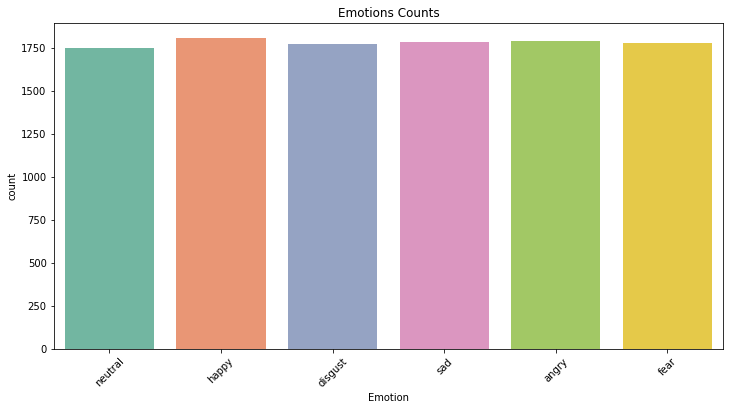

In [15]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

## Splitting Dataset

In [16]:

def get_splits(df: pd.DataFrame):

    # Defines ratios, w.r.t. whole dataset.
    ratio_train = 0.7
    ratio_val = 0.20
    ratio_test = 0.10

    # Produces test split.
    remaining, test = train_test_split(
        df, test_size=ratio_test, stratify=df['Emotion'])

    # Adjusts val ratio, w.r.t. remaining dataset.
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining

    # Produces train and val splits.
    train, val = train_test_split(
        remaining, test_size=ratio_val_adjusted, stratify=remaining['Emotion'])
    
    return train, val, test 

In [17]:
train, val, test = get_splits(main_df)
len(train), len(val), len(test)

(7470, 2135, 1068)

# New stuff

In [18]:
# Compute Spectrogram from audio

def Audio2Mfcc(audio):

    stfts = tf.signal.stft(audio, frame_length=CFG.n_fft, frame_step=CFG.hop_len,
                        fft_length=CFG.n_fft)
    spectrograms = tf.abs(stfts)


    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    64, # Can be changed
    num_spectrogram_bins, 
    CFG.sample_rate, 
    CFG.fmin,
    CFG.fmax)

    mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)

    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :32]
    return mfccs


def Audio2Spec(audio,spec_shape=[256, 128],sr=16000,nfft=2048,window=2048,fmin=20,fmax=8000):
    spec_time = spec_shape[0]
    spec_freq = spec_shape[1]
    audio_len = tf.shape(audio)[0]
    hop_length = tf.cast((audio_len // (spec_time - 1)), tf.int32) # compute hop_length to keep desired spec_shape
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length) # convert to spectrogram
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_freq, fmin=fmin, fmax=fmax) # transform to melscale
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80) # from power to db (log10) scale
    if tf.shape(db_mel_spec)[0] > spec_time:  # check if we have desiered shape
        db_mel_spec = db_mel_spec[:spec_time,:]
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)


    return db_mel_spec

# Convert spectrogram (H,W) to image (H,W,1)
def Spec2Img(spec, num_channels=1):
    # 1 channel image
    img = spec[..., tf.newaxis]
    # Copy same image across channel axis
    if num_channels>1:
        img = tf.tile(img, [1, 1, num_channels])
    return img

In [19]:
# Decode audio from wav
def decode_audio(data):

    # Decode
    audio, sr = tf.audio.decode_wav(data)


    audio = tf.cast(audio,tf.float32)
    # Normalization
    if CFG.normalize:
        audio = Normalize(audio)
    return audio

skippedFiles = []
# Read tfrecord data & parse it & do augmentation
def save_img(file, label, set, count, augment=True, return_id=False, return_label=True, target_len=CFG.audio_len, spec_shape=CFG.spec_shape):
    
    audio = tf.io.read_file(file)


    # # Decoding
    try:
        audio = decode_audio(audio)  # decode audio from .wav
    except Exception as e:
        skippedFiles.append(file)
        return


    try:
        audio = tf.squeeze(audio, axis=[-1]) # remove channel dimension
    except:
        skippedFiles.append(file)
        return
    

    # audio = tf.cast(audio, tf.float32) / 32768.0

    # Trim Audio
    audio = TrimAudio(audio)
    # Crop or Pad audio to keep a fixed length
    audio = CropOrPad(audio, target_len)
    if augment:
        # Apply AudioAug
        audio = AudioAug(audio)
    # Compute Spectrogram
    # spec = Audio2Spec(audio, spec_shape=spec_shape)
    spec = Audio2Mfcc(audio)
    if augment:
        # Apply SpecAug
        spec = SpecAug(spec)
    # Spectrogram (H, W) to Image (H, W, C)
    img = Spec2Img(spec, num_channels=1) 
    # Clip & Reshape
    img = tf.clip_by_value(img, 0, 1) if CFG.clip else img
    # print(img)
    # img = tf.reshape(img, [..., 1])

    img = img.numpy().transpose()[0]
    cm = plt.cm.get_cmap('jet')
    plt.tight_layout();
    plt.grid(False)

    if augment:
        plt.imsave(f'./features/images/new/{set}/{label}_{count}_augged.png', img, cmap=cm)
    else:
        plt.imsave(f'./features/images/new/{set}/{label}_{count}.png', img, cmap=cm)
    
    plt.cla()
    plt.close("all")

    # Save image
    # img = tf.image.convert_image_dtype(img, tf.uint8)
    # img = tf.image.encode_png(img)
    # tf.io.write_file(f'./features/images/new/{set}/{label}_{count}.png', img)

In [20]:
for i, row in tqdm(train.iterrows(), total=len(train)):
        save_img(row['File_Path'], row['Emotion'], 'train', i)

  0%|          | 0/7470 [00:00<?, ?it/s]2022-09-24 08:24:26.641565: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-09-24 08:24:26.641595: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: archlinux
2022-09-24 08:24:26.641600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: archlinux
2022-09-24 08:24:26.641770: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.76.0
2022-09-24 08:24:26.641790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-24 08:24:26.641795: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.76.0 -- cannot find working devices in this configuration
2022-09-24 08:24:26.642610: I tensorflow/core/platform

In [21]:
for i, row in tqdm(train.iterrows(), total=len(train)):
        save_img(row['File_Path'], row['Emotion'], 'train', i, augment=False)

100%|██████████| 7470/7470 [07:23<00:00, 16.84it/s] 


In [22]:
for i, row in tqdm(val.iterrows(), total=len(val)):
        save_img(row['File_Path'], row['Emotion'], 'val', i, augment=False)

100%|██████████| 2135/2135 [02:12<00:00, 16.15it/s]


In [23]:
for i, row in tqdm(test.iterrows(), total=len(test)):
        save_img(row['File_Path'], row['Emotion'], 'test', i, augment=False)

100%|██████████| 1068/1068 [01:03<00:00, 16.71it/s]


In [24]:
sorted(skippedFiles)

['../Datasets/custom/fear_176.wav', '../Datasets/custom/fear_176.wav']